We implement MLP based on this paper: https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

PyTorch Internals: http://blog.ezyang.com/2019/05/pytorch-internals/

Our goal this week is to implement the MLP network as outlined in the "A Neural Probabilistic Language Model" paper by Bengio. In the previous week, we used 1-hot encoding as our input, however as we have previously mentioned in this course, Word2Vec allows us to learn features, which can serve to increase efficiency of the model by providing context rich inputs. Within the paper, they use a 17000 word vocabulary and test the approach with m = 30,60,100, where m is number of features within each vector. They train the model by maximizing the negative log likelyhood, just like our approach in week 8. 

In our case, we will be simplifying the problem, we will once again be using "names.txt" dataset and attempting to teach the network how to generate realistic sounding names. 


In [1]:
import torch as torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
words = open("names.txt", "r").read().splitlines()
print(words[:8])
print(len(words))

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
32033


(-0.5, 790.5, 583.5, -0.5)

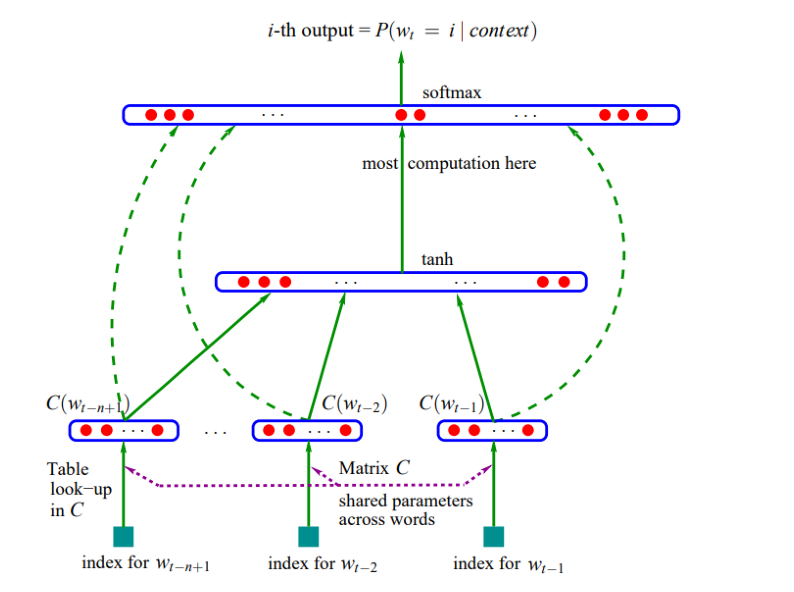

In [3]:
plt.figure(figsize=(10,10))
plt.imshow(plt.imread("MLP.png"))
plt.axis("off")

The image above shows the network that we are trying to implement. The indexes (Wt-n+1,..., Wt-2, Wt-1), represent the tokens used to predict the next output. In the paper, they used words as tokens, but in our case where we want to create a character level network, capable of generating realistic names, we will be using characters. 

C(), represents the look up table for Word2Vec, We pass in the token to access it's vector representation. 
tanh, is the hidden neural layer, it's size is up to the developer to optimize, based on whether the network is underfitting or overfitting. 

The Softmax, as usual serves to give us a nice probaility distribution. 

final layer should have the same amount of neurons as there are possible outputs. In our case, we will have 27 neurons, because we only generate 27 types of outputs. In case of the paper, they had 17000 output neurons. 

In [4]:
# As in previous week, in order to work with Tensors, we need 
# stoi -> String to integer dictionary
# itos -> integer to String dictionary

chars = sorted(list(set("".join(words))))
stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i: s for s, i in stoi.items()}

print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


For starters, we will create a toy dataset with 5 words

In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
  
  print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

Now let's start working on creating the Look Up Tables for our vector representations. 

The researchers created vectors with 30-100 features in them, in order to represent 17000 words more effectively. In our case, we only have 27 characters to represent as vectors so even a feature vector as short as 2 features may suffice. 

In [7]:
C = torch.randn((27,2))

# If we are being faithful to the graph given in the paper, the most direct translation would be #1 approach
# ie, 1-hot encoding the input '5', and then multiplying it by the look up table to get the vector representation 

# But, since approach in #2 is technically the same but much faster, we will be using that. 

# 1- using one hot
print(F.one_hot(torch.tensor([5]), num_classes=27).float() @ C)

# 2- direct indexation. 
print(C[5])


tensor([[ 0.2431, -1.6918]])
tensor([ 0.2431, -1.6918])


In [8]:
# Now we may embed the entire Training tensor

emb = C[X]
emb.shape   #torch.Size([32, 3, 2])

# as we can see, the first element has the same weights and is to be expected as the first entry in X was 3 identical '.'-s
# In the next entry, we can see 2 identical weights, followed by a differing entry. as next entry is '.', '.', 'e'.
emb

tensor([[[ 2.0903, -0.6520],
         [ 2.0903, -0.6520],
         [ 2.0903, -0.6520]],

        [[ 2.0903, -0.6520],
         [ 2.0903, -0.6520],
         [ 0.2431, -1.6918]],

        [[ 2.0903, -0.6520],
         [ 0.2431, -1.6918],
         [-1.4051, -0.1660]],

        [[ 0.2431, -1.6918],
         [-1.4051, -0.1660],
         [-1.4051, -0.1660]],

        [[-1.4051, -0.1660],
         [-1.4051, -0.1660],
         [ 0.0850,  0.0411]],

        [[ 2.0903, -0.6520],
         [ 2.0903, -0.6520],
         [ 2.0903, -0.6520]],

        [[ 2.0903, -0.6520],
         [ 2.0903, -0.6520],
         [ 0.9927,  1.4591]],

        [[ 2.0903, -0.6520],
         [ 0.9927,  1.4591],
         [-0.9207,  0.1001]],

        [[ 0.9927,  1.4591],
         [-0.9207,  0.1001],
         [-0.4680,  0.0713]],

        [[-0.9207,  0.1001],
         [-0.4680,  0.0713],
         [ 0.6619,  0.3006]],

        [[-0.4680,  0.0713],
         [ 0.6619,  0.3006],
         [-0.4680,  0.0713]],

        [[ 0.6619,  0

Now, we can move on to building the model, more specifically the hidden layers

In [9]:
num_of_inputs = 6       # This is because we have 3, 2 Dimensional inputs for each neuron. 3 * 2 = 6
num_of_hidden = 100     # Just a rough number of hidden neurons chosen for the start

W1 = torch.randn((6, 100)) 
b1 = torch.randn(100)

# our emb tensor is of the shape torch.Size([32, 3, 2]) and this causes problems. 
# We need to convert it into torch.Size([32, 6]) in order to multiply by the hidden layer W1
# Looking into the documentation, first instinct may be to use the built in concatanation method
# torch.cat([emb[:, 0, :],emb[:, 1, :],emb[:, 2, :] ], 1).shape


# While that works, there is a more elegant solution, if you understand how Tensors work in PyTorch. 
# A good resource is this: http://blog.ezyang.com/2019/05/pytorch-internals/
# But to summarize 
h = emb.view(-1, num_of_inputs) @ W1 + b1

In [10]:
a = torch.arange(18)  # tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])
a.shape               # torch.Size([18])
a.view(3,3,2)         # as long as multiplication is equal to the number of terms, ie, 3 * 3 * 2 = 18 then we can transform
                      # The tensors however we wish
                      
# So in essence what emb.view(-1, num_of_inputs), -1 is a placeholder that PyTorch replaces with the appropriate value to maintain the total number of elements. 
# while "num_of_inputs", is simply the dimension we wish to obtain instead of (3,2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

Now, let's create the output layer

In [11]:
out_size = 27 # no. of neurons

W2 = torch.randn((num_of_hidden, out_size))
b2 = torch.randn(out_size)

logits = h @ W2 + b2

logits.shape        # [number of samples processesed simultaneously, number of output neurons]

torch.Size([32, 27])

In [1]:
logits[1]

NameError: name 'logits' is not defined

Now let's apply softmax

In [13]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

prob.sum(dim = 1) # All rows, now sum to 1, hence they are normalized. 

tensor([1.0000, 1.0000, 1.0000,    nan, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

It is imperative we also calculate loss for training purposes. 

In [14]:
# current probabilities of the correct labels y_true (with current weights)
print(prob[torch.arange(32), Y])         # if the probability for the correct character being generated is low, then that's bad

# nll loss
loss = - prob[torch.arange(32), Y].log().mean()
loss

tensor([1.5046e-30, 8.2238e-10, 1.9437e-17, 0.0000e+00, 2.2631e-10, 7.8179e-11,
        3.8676e-43, 6.4547e-30, 2.6608e-39, 1.4044e-07, 7.7261e-05, 4.5751e-13,
        0.0000e+00, 1.0503e-18, 0.0000e+00, 1.2142e-08, 1.1211e-19, 1.1070e-29,
        0.0000e+00, 1.5673e-05, 8.6074e-12, 1.8456e-31, 5.1175e-33, 1.3024e-33,
        7.1386e-11, 4.2769e-35, 5.2420e-08, 3.9459e-22, 4.8764e-20, 3.1216e-24,
        3.0883e-33, 2.0622e-24])


tensor(inf)

##### Truth be told, There is a much easier way to calculate the negative log loss than manually applying softmax and finding nll. 

Not, only is it simpler and easier to maintain but it also has better performance for 3 reasons:

1) Forward Pass Efficiency:
    * Shared Computation: combines the softmax and the computation of the cross-entropy loss in a single step. Also, no need to create intermediary variables. 
2) Backwards propagation efficiency: 
    * Simplification of Gradient Formula: In manual methods, the gradient of the loss with respect to the logits requires computing derivatives through the softmax function, which involves more complex expressions. F.cross_entropy simplifies this by computing these derivatives internally in a more optimized manner, thereby speeding up the learning process.

3) Numerically better behaved:
    * Handling of Large Logit Values: A common problem with manually computing the softmax function is the potential for floating-point overflow when exponentiating large positive numbers. For instance, consider a logit value of 100. The exponential of 100 in Python results in a value on the order of 2.688 x 10^43, which can lead to overflow issues in many systems, especially in a 32-bit floating point context.
    * Log-Sum-Exp Trick: F.cross_entropy mitigates this by employing the log-sum-exp trick. This technique involves subtracting the maximum logit value before exponentiating, thus bringing the maximum exponentiated value close to 1 and making other values very small (close to zero but not causing underflow). This operation dramatically stabilizes the computation by keeping values within a range that is manageable for floating-point representation. For example, if the logits are [100, 101, 102], the log-sum-exp trick subtracts 102 (the max logit) from each logit before exponentiating, resulting in exponentiations of much smaller and manageable numbers [0, 1, 2], reducing the risk of overflow.


In [15]:
# Thanks to PyTorch we can simply summon F.cross_entropy()

# calculate the loss
# 1- Manual
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdims = True)
# loss = - prob[torch.arange(32), Y].log().mean()

# 2- Using Cross Entropy 
loss = F.cross_entropy(logits, Y)

Now we can Summarize the network and everything we have done so far

In [16]:
num_of_inputs = 6
num_of_hidden = 100
out_size = 27

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((num_of_inputs, num_of_hidden), generator = g)
b1 = torch.randn(num_of_hidden, generator = g)
W2 = torch.randn((num_of_hidden, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(f"number of params = {sum(p.nelement() for p in parameters)}")

number of params = 3481


In [17]:
emb = C[X]

h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
logits = h @ W2 + b2

loss = F.cross_entropy(logits, Y)

loss

tensor(10.1065)

In [18]:
# marking all the tensors that we defined in "parameters" as learnable, allowing gradients to be calculated and thus parameters to be adjusted. 

for p in parameters:
    p.requires_grad = True

Finally, we will use 32 examples in the dataset to train the network. Due to it's low example amount, the model should overfit and thus give us really low loss. 

In [19]:
for _ in range(100):

    # Forward Pass
    emb = C[X]
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y)

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(loss.item())

0.5580253005027771


Training

1) We will split the dataset into Training, Development and Testing data sets. This is done in order to check on models generalization capabilities, as well as observe if the model is underfitting or overfitting. The split will be 80/10/10


In [20]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])        # 0-80% 
Xdev, Ydev = build_dataset(words[n1:n2])    # 80-90%
Xte, Yte = build_dataset(words[n2:])        # 90%-100%

Xtr.shape, Ytr.shape 

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


(torch.Size([182625, 3]), torch.Size([182625]))

In [21]:
num_of_inputs = 6
num_of_hidden = 100
out_size = 27

g = torch.Generator().manual_seed(2147483647)
C = torch.rand((27, 2), generator = g)
W1 = torch.randn((num_of_inputs, num_of_hidden), generator = g)
b1 = torch.randn(num_of_hidden, generator = g)
W2 = torch.randn((num_of_hidden, out_size), generator = g)
b2 = torch.randn(out_size, generator = g)

parameters = [C, W1, b1, W2, b2]

for p in parameters:
    p.requires_grad = True

We can train the dataset by calculating true gradient according to the entire dataset, or we can do mini-batch learning. 

You can think of mini-batch vs full dataset gradient descents, as a drunk man trying to go down a hill versus a very careful sober man trying to go down a hill. as a rule of thumb, if the careful man has to do a lot of calculations with every move he takes, then the drunk man that makes a lot of rash decisions that may not always be the best ones, will still converge faster. In similar way, if the dataset is large, it's generally faster to use mini-batch learning. 

In [60]:
for _ in range(100):

    # Forward Pass
    emb = C[Xtr]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr)

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(f"mini batch loss {loss.item()}")

mini batch loss 2.923375368118286


In [64]:
for _ in range(100):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    for p in parameters:
        p.data -= 0.1 * p.grad

print(f"mini batch loss {loss.item()}")

mini batch loss 3.038679361343384


Now, let's optimize learning rate

Text(0.5, 1.0, 'stepping between exponents')

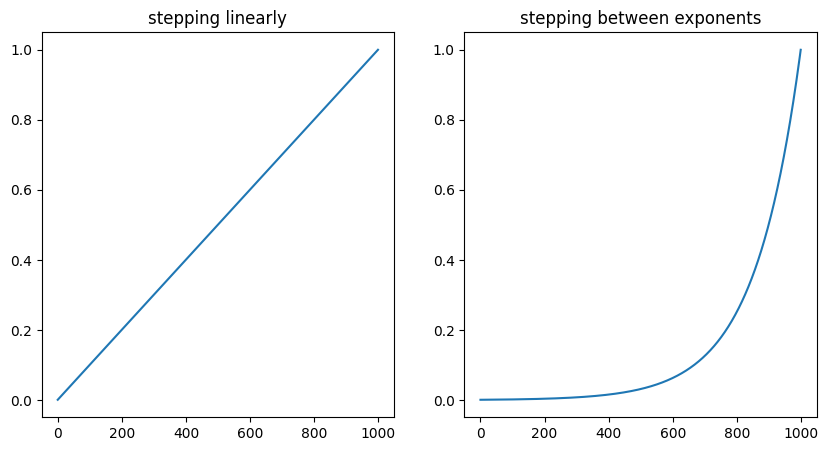

In [22]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

# plot both next to each other
fig, axes = plt.subplots(1,2, figsize = (10,5))

axes[0].plot(torch.linspace(0.001, 1, 1000))
axes[0].set_title("stepping linearly")

axes[1].plot(lrs)
axes[1].set_title("stepping between exponents")

In [23]:
lossi = []

for i in range(1000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    lr = lrs[i]
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())

print(f"mini batch loss {loss.item()}")

mini batch loss 8.277443885803223


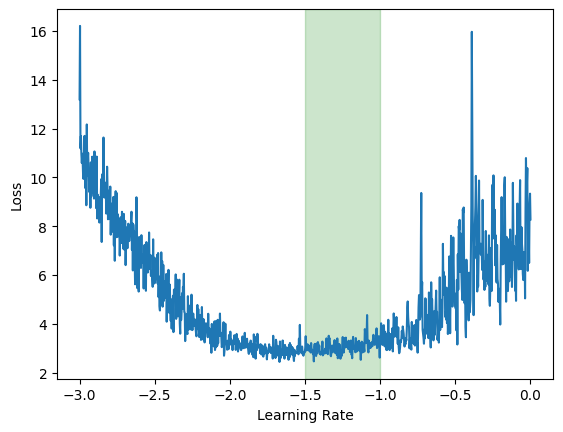

In [24]:
plt.plot(lre, lossi)

plt.axvspan(-1.5, -1, color='g', alpha=0.2)
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.show()

In [28]:
lossi = []

for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,)) # now size of emb is (32, 3, 2) again

    # Forward Pass
    emb = C[Xtr[ix]]
    # print(emb.shape)
    h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward Pass
    for p in parameters:
        p.grad = None

    loss.backward()

    # update
    # set lr to 0.1, then to 0.01 
    lr = 0.01
    for p in parameters:
        p.data -= lr * p.grad

    # track loss
    lossi.append(loss.item())

print(f"mini batch loss {loss.item()}")

# Forward Pass
emb = C[Xdev]
# print(emb.shape)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)

print(f"Dev set loss {loss.item()}")

mini batch loss 2.4565160274505615
Dev set loss 2.4803414344787598


In [29]:
# Forward Pass
emb = C[Xtr]
# print(emb.shape)
h = torch.tanh(emb.view(-1, num_of_inputs) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)

print(f"Training set loss {loss.item()}")

# Since dev and training sets have similar losses, the model is not overfitting. rather it is likely underfitting. 
# Hint: modifying tanh layer, increasing context length and so on can improve the model performance. 

Training set loss 2.4840846061706543


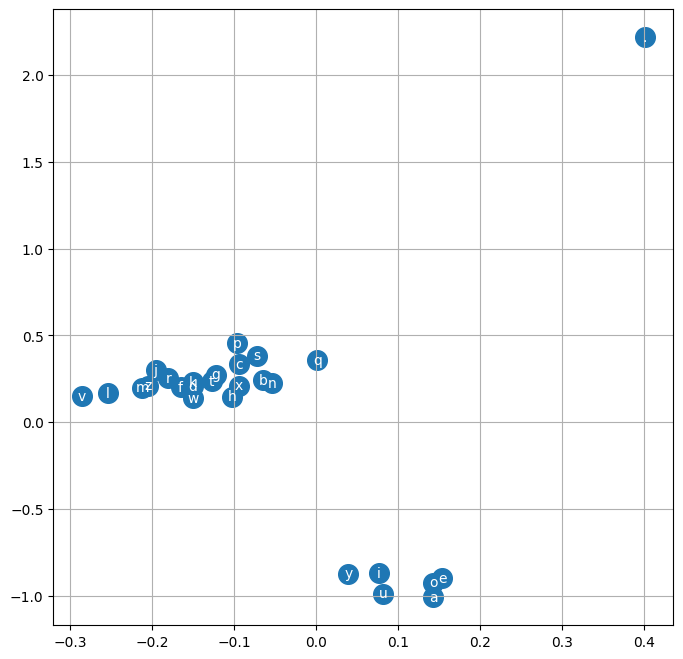

: 

In [30]:
# Let's visualize the vector representations that we have obtained for each character. 

plt.figure(figsize = (8,8))
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")